# Figure 4 ($Q_\alpha$) and additional scenarios (appendix C)

In [1]:
from concurrent.futures import ProcessPoolExecutor, as_completed
import gzip
from pathlib import Path
import pickle

import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from scipy import stats

import hypney.all as hp

import common
from common import ibm, signal, draw_limits, log_x, log_y

In [2]:
plt.rcParams["text.usetex"] =  True

### Setup different methods

In [3]:
fixed_hawk = hp.FixedRegionSimpleHawk
allregion_hawk = hp.AllRegionSimpleHawk
stat_prefix = 'lr'

methods = dict(
    full_space=dict(
        statistic=fixed_hawk(signal, cuts=((0, 1),), signal_only=True), 
        dist_name=f'{stat_prefix}_full',
        style=dict(color="k", linestyle="-"), 
        label="Full space"
    ),
#     clean_only=dict(
#         statistic=fixed_hawk(signal, cuts=((.5, 1),), signal_only=True), 
#         dist_name=f'{stat_prefix}_half',
#         style=dict(color="k", linestyle=':'), 
#         label="Right half"),
#     two_regions=dict(
#         statistic=fixed_hawk(signal, cuts=((0, 1), (.5, 1)), signal_only=True), 
#         dist_name=f'{stat_prefix}_half_and_full',
#         style=dict(color="g"), 
#         label="Full and r. half"),


    all_regions=dict(
        statistic=allregion_hawk(signal, signal_only=True),
        dist_name=f'{stat_prefix}_all',
        style=dict(color=ibm['blue'], linewidth=1.5), 
        label="All intervals"
    ),
#     gaps=dict(
#         statistic=allregion_hawk(signal, signal_only=True, n_max=0),
#         dist_name=f'{stat_prefix}_gaps', 
#         style=dict(color="steelblue"),
#         label="$I_0$ (gaps)"
#     ),

    right_regions=dict(
        statistic=allregion_hawk(signal, signal_only=True, regions_type='right'),
        dist_name=f'{stat_prefix}_oneside',
        style=dict(color=ibm['gold'],),
        label=r"$(\ldots, 1]$ intervals"),
    left_regions=dict(
        statistic=allregion_hawk(signal, signal_only=True, regions_type='left'),
        dist_name=f'{stat_prefix}_oneside',
        style=dict(color=ibm['red'], alpha=0.5),
        label=r"$[0,\ldots)$ intervals"),
    left_right_regions=dict(
        statistic=allregion_hawk(signal, signal_only=True, regions_type=('left', 'right')),
        dist_name=f'{stat_prefix}_left_right',
        style=dict(color=ibm['orange']),
        label="One end at 0/1",
    ),

    central_regions_asym=dict(
        statistic=allregion_hawk(signal, signal_only=True,
                                 regions_type='central', central_point=0.5),
        dist_name=f'{stat_prefix}_central_asym',
        style=dict(color='olivedrab'),
        label="Central intervals (have 0.5)",
    ),
    
    central_regions_sym=dict(
        statistic=allregion_hawk(signal, signal_only=True, 
                                 regions_type='central_symmetric', central_point=0.5),
        dist_name=f'{stat_prefix}_central_sym',
        style=dict(color='olivedrab', linestyle="--"),
        label="Central symmetric",
    ),

    
#     s3=dict(
#         statistic=fixed_hawk(signal, cuts=hp.uniform_sn_cuts(3), signal_only=True), 
#         dist_name=f'{stat_prefix}_s3',
#         style=dict(color=ibm['purple']), 
#         label="$S_3$"),
    s4=dict(
        statistic=fixed_hawk(signal, cuts=hp.uniform_sn_cuts(4), signal_only=True), 
        dist_name=f'{stat_prefix}_s4',
        style=dict(color=ibm['purple']), 
        label="$S_4$"),
#     s5=dict(
#         statistic=fixed_hawk(signal, cuts=hp.uniform_sn_cuts(5), signal_only=True), 
#         dist_name=f'{stat_prefix}_s5',
#         style=dict(color="g", linestyle=':'), 
#         label="$S_5$"),
    s10=dict(
        statistic=fixed_hawk(signal, cuts=hp.uniform_sn_cuts(10), signal_only=True), 
        dist_name=f'{stat_prefix}_s10',
        style=dict(color=ibm['purple'], linestyle=':'),
        label="$S_{10}$"),

)

# Build/load distributions
n_toys_dist = 10_000
for method_name, r in methods.items():
    r['statistic'] = r['statistic'].with_stored_dist(r['dist_name'], n_toys=n_toys_dist)

## Critical value plot

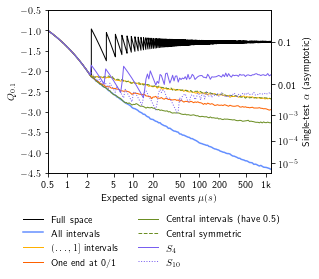

In [4]:
mu_signal = hp.DEFAULT_RATE_GRID

# Transformation to apply to the statistic
# I added the square root in $t$ very late in the study,
# and it affects only the raw values of the statistic.
# (not limits set using it).
f_y = lambda x: np.sqrt(np.abs(x)) * np.sign(x)

#plt.figure(figsize=(3.5, 3.5))
plt.figure(figsize=(4, 3))


# Analytic solution for full space (Poisson test)
mu_dense =np.geomspace(0.1, 1200, 10_000)
plt.plot(mu_dense,
         common.t0(mu_dense, n=stats.poisson(mu_dense).ppf(0.1)),
         **{**dict(linewidth=1), **methods['full_space']['style']},
         label='Full space')

for method_name, r in methods.items():
    if method_name in ('left_regions', 'full_space'):
        continue
    ppf = r['statistic'].dist.ppf
    plt.plot(mu_signal, 
             f_y(ppf(quantiles=0.1, rate=mu_signal)), 
             **{**dict(linewidth=1), **r['style']}, label=r['label'])
#     plt.fill_between(
#         mu_signal, 
#         ppf(quantiles=0.08, rate=mu_signal),
#         ppf(quantiles=0.12, rate=mu_signal),
#         linewidth=0, **r['style'], alpha=0.2
#     )
    
plt.xlabel("Expected signal events $\mu(s)$")
log_x(0.5, 1200)
xticks = plt.xticks()[0]
plt.xticks(xticks, ['%g' % x for x in xticks[:-1].tolist()] + ['1k'])


plt.ylabel("$Q_{0.1}$")
stat_lims = dict(pn=(2e-5, 1), lr=(-4.5, -0.5))[stat_prefix]
plt.ylim(*stat_lims)
if stat_lims[0] > 0:
    log_y(*stat_lims, scalar_ticks=False)
    
legend = plt.legend(
    #bbox_to_anchor=(1.2, 1), 
    bbox_to_anchor=(-0.15, -0.2),
    ncol=2,
    loc='upper left', 
    frameon=False)

# x = np.geomspace(0.5, 1200)
# plt.plot(x, 0.2 / x**1.3, c='k')

ylim = plt.ylim()
plt.twinx()
plt.ylim(*ylim)

if stat_prefix == 'pn':
    plt.yscale('log')
    n_indep = np.array([1, 2, 5, 10, 20, 50, 100, 200, 500, 1000, 2000, 5000])
    p_n_indep = 1 - (1 - 0.1)**(1/n_indep)
    assert p_n_indep.min() > p_lims[0]
    plt.yticks(p_n_indep, [str(x) for x in n_indep])
    plt.ylabel("Equiv. trial factor")
    
elif stat_prefix == 'lr':
    labels, alphas = list(zip(*[
        ('0.1', 0.1),
        #('$2\\sigma$', stats.norm.cdf(-2)),
        ('0.01', 0.01),
        #('$3\\sigma$', stats.norm.cdf(-3)),
        ('$10^{-3}$', 0.001),
        ('$10^{-4}$', 0.0001),
        #('$4\\sigma$', stats.norm.cdf(-4)),
        ('$10^{-5}$', 1e-05)
    ]))
    c_alpha = -stats.chi2(1).ppf(1 - 2 * np.asarray(alphas))
    
    plt.yticks(f_y(c_alpha), labels)
    plt.ylabel(r"Single-test $\alpha$ (asymptotic)")

for fmt in ['pdf', 'png']:
    plt.savefig(f'crit_quantiles_{stat_prefix}.{fmt}', dpi=200, 
                bbox_inches='tight', bbox_extra_artists=[legend])
plt.show()

### Single-scenario sensitivity plots

Define scenarios

In [5]:
studies = dict(
    true_sig=dict(
        bg=signal,
        scale_min=1,
        show_relative=True,
        skip_methods=[k for k in methods.keys()
                      if k not in ('all_regions', 'full_space')
                     ],
    ),
    
    halfbad=dict(
        bg=common.block_bg(),
        limit_max=20,
        show_relative=False,
        skip_methods=['central_regions_sym', 'central_regions_asym', 
                      #'left_right_regions'
                     ],
    ),
    triangle=dict(
        bg=common.triangle_bg(),
        scale_min=0.1,
        skip_methods=['central_regions_sym', 'central_regions_asym', 
                      #'left_right_regions',
                      'clean_only', 'two_regions'],
    ),
    staircase=dict(
        bg=common.staircase_bg(),
        scale_min=0.45,
        scale_asymptote=common.staircase_bg().diff_rate(1),
        skip_methods=['central_regions_sym', 'central_regions_asym', 
                      #'left_right_regions'
                     ],
    ),
    halfpipe=dict(
        bg=common.halfpipe_bg(),
        scale_min=0.15,
        skip_methods=[#'right_regions', 
                      'left_regions', 
                      'left_right_regions',
                      'clean_only', 'two_regions'],
        scale_asymptote=common.halfpipe_bg().diff_rate(0.5),
    ),  
#     halfpipe_narrow=dict(
#         bg=halfpipe_narrow,
#         scale_min=0.1,
#         skip_methods=[#'right_regions', 
#                       'left_regions', 
#                       'left_right_regions',
#                       'clean_only', 'two_regions'],
#     ),  
    halfpipe_asym=dict(
        bg=common.halfpipe_asym(),
        scale_min=0.1,
        skip_methods=[#'right_regions', 
                      'left_regions', 
                      'left_right_regions',
                      'clean_only', 'two_regions'],
        scale_asymptote=common.halfpipe_asym().diff_rate(np.linspace(0, 1, 10_000)[:-1]).min(),
    )
)

Get limits

In [6]:
def get_limits(unknown_bg, study_name, n_trials, batch_size=100):
    n_batches = n_trials // batch_size

    cache_folder = Path(f'./extra_scenarios/limits_{stat_prefix}_{study_name}/')
    cache_folder.mkdir(exist_ok=True)
    key = f'limits_{study_name}'

    for method_name, r in methods.items():
        if method_name.startswith('s'):
            continue
        
        cache_fn = cache_folder / f"{method_name}_{n_trials}_{rate_unknown.size}.pkl.gz"
        if cache_fn.exists():
            with gzip.open(cache_fn, mode='rb') as f:
                r[key] = pickle.load(f)
        else:
            print(f"Did not find {cache_fn}, running toy mcs")
            stat = r['statistic']
            
            # TODO: maybe don't need ,tolist anymore after rstart
            ul = hp.UpperLimit(stat, anchors=hp.DEFAULT_RATE_GRID.tolist(), ppf_fudge=-1e-8)

            r[key] = np.full((rate_unknown.size, n_trials), float('inf'))
            for i, m in enumerate(tqdm(rate_unknown, desc=r['label'])):
                source = unknown_bg(rate=m)

                with ProcessPoolExecutor(max_workers=7) as exc:
                    futures = [
                        exc.submit(draw_limits, ul, source, batch_size) 
                        for _ in range(n_batches)]
                    r[key][i] = np.concatenate([x.result() for x in as_completed(futures)])
                    
                if np.isfinite(r[key][i]).mean() < 0.9:
                    # Too many limits out of bounds, no point
                    # in simulating higher counts.
                    break

            with gzip.open(cache_fn, mode='wb') as f:
                pickle.dump(r[key], f)
                

In [7]:
rate_unknown = np.geomspace(0.1, 1000, 4 * 4 + 1)

# 2000 trials: about 2.5 min per study/method combination, with paralellization.
# So about 2.5m * (4 * 13) = 130 mins
# actually I and I0 take more like 4min, so more like 2.5-3hours.
n_trials = 1000 #2000
max_n = 1200
min_valid = 0.8

for study_name, s in studies.items():
    print(study_name)
    get_limits(s['bg'], study_name, n_trials=n_trials)

    for method_name, r in methods.items():
        if method_name in s['skip_methods'] or method_name.startswith('s'):
            continue
        
        x = r[f'limits_{study_name}']
        valid_f = np.mean(x < max_n, axis=1)
        r[f'{study_name}_mean'] = np.where(
            valid_f > min_valid,
            x.clip(None, max_n).mean(axis=1),
            float('nan')
        )
        r[f'{study_name}_err'] = np.where(
            valid_f > min_valid,
            x.clip(None, max_n).std(axis=1) / x.shape[1]**0.5,
            0
        )

true_sig
halfbad
triangle
staircase
halfpipe
halfpipe_asym


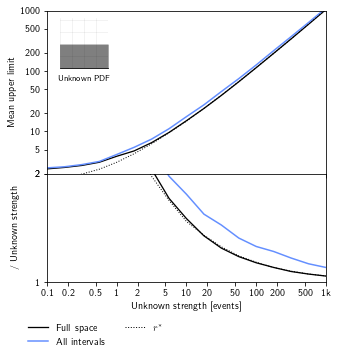

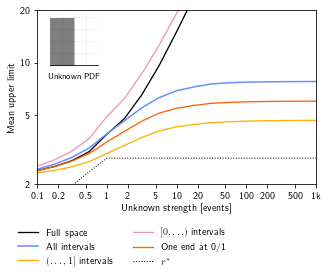

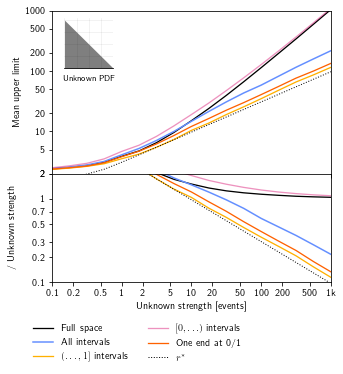

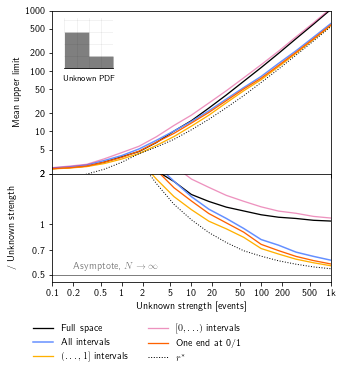

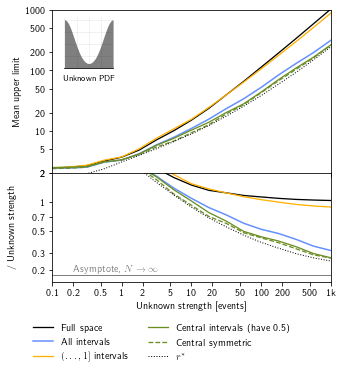

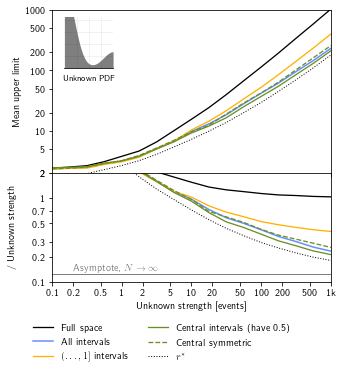

In [8]:
show_bars = False
poisson_kind = 'augmented'

with gzip.open(f'clairvoyant_sens_{poisson_kind}.pkl.gz', mode='rb') as f:
    clairvoyant_sens = pickle.load(f)

for study_name, study in studies.items():
    #plt.figure(figsize=(5, ))
    show_rel = study.get('show_relative', True)
    if show_rel:
        height = 5
        fig, axes = plt.subplots(
            2, 1, 
            figsize=(5, height),
            gridspec_kw=dict(height_ratios=[1.5,1]),
            sharex=True)
        scales = 1, rate_unknown
    else:
        height = 3.2
        fig = plt.figure(figsize=(5, height))
        axes = [plt.gca()]
        scales = [1]

    for scale, ax in zip(scales, axes):
        for method_name, r in methods.items():
            if method_name in study.get('skip_methods', []) or method_name.startswith('s'):
                continue
                
            mean = r[f'{study_name}_mean']
            opts = dict(
                **{**dict(linewidth=1.3), **r['style']},
                label=r['label'])
            if show_bars:
                err = r[f'{study_name}_err']
                ax.errorbar(rate_unknown, mean / scale, yerr=err / scale, 
                            #marker='.',
                            **opts)
            else:
                ax.plot(rate_unknown, mean / scale, **opts)

        if study_name in clairvoyant_sens:
            ax.plot(rate_unknown, 
                    np.interp(
                        rate_unknown, 
                        clairvoyant_sens['mu_unknown'],
                        clairvoyant_sens[study_name]) / scale,
                    c='k', label='$r^*$', linewidth=1,
                    linestyle=':')
                
        
    plt.sca(axes[0])
    #plt.title(study_name)
    
    log_x(0.1, 1000, tick_at=[1, 2, 5, 10])
    xticks = plt.xticks()[0]
    plt.xticks(xticks, ['%g' % x for x in xticks[:-1].tolist()] + ['1k'])
    
    log_y(2, study.get('limit_max', 1000), tick_at=[1,2,5,10])
    plt.ylabel("Mean upper limit")


    xlabel = "Unknown strength [events]"
    if show_rel:
        ax = axes[1]
        plt.sca(ax)
        plt.xlabel(xlabel)
        plt.ylabel("/ Unknown strength", labelpad=15)
        log_y(study.get('scale_min', 0.5),
              2, 
              tick_at=[1, 2, 3, 5, 7])
        
        if 'scale_asymptote' in study:
            yline = study['scale_asymptote']
            style = dict(c='k', alpha=0.5)
            plt.axhline(yline,
                        **style, linewidth=1)
            plt.text(0.2, yline * 1.05,
                     r"Asymptote, $N \rightarrow \infty$", **style,
                     va='bottom')

        plt.subplots_adjust(hspace=0)
    else:
        plt.xlabel(xlabel)

    legend = plt.legend(
        #bbox_to_anchor=(1,1.05), 
        bbox_to_anchor=(-0.1, -0.3 if show_rel else -0.2),
        loc='upper left', 
        ncol=2,
        frameon=False)
        
    # add_axes([xmin,ymin,dx,dy])
    plt.sca(fig.add_axes([0.16, 0.72 if show_rel else 0.64, 
                          0.135, 0.2 * 3.5/height]))
    common.sketch_dist(study['bg'])
        
    for fmt in ['pdf', 'png']:
        plt.savefig(
            f'{study_name}_{stat_prefix}_{n_trials}_{rate_unknown.size}.{fmt}',
            dpi=200, bbox_inches='tight', bbox_extra_artists=[legend])
    plt.show()